# 5 モデルの評価と改良

In [1]:
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# 合成データセットの生成
X,y=make_blobs(random_state=0)
# dataトラベルを訓練セットとテストセットに分割
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=0)
# モデルのインスタンスを生成し、訓練データで学習
logreg=LogisticRegression().fit(X_train,y_train)
# テストセットでモデルを評価
print("Test set score: {:.2f}".format(logreg.score(X_test,y_test)))

Test set score: 0.88


* データを訓練セットとテストセットに分割するのは、新しく見たことのないデータに対する汎化性能を計測するため
* 交差検証（cross-validation）はより頑健な汎化性能評価手法
* クラス分類や回帰性能を評価する手法についても、scoreメソッドのデフォルトのR^2よりも良い方法を議論する
* 教師あり学習モデルに対して、汎化性能が最大になるように効率的にパラメータを調整するグリッドサーチについて学ぶ

## 5.2 交差検証
* 交差検証（cross-validation）は汎化性能を評価する統計的手法で、ただ訓練セットとテストセットに分割する方法と比べて、より安定で徹底した手法
* 最もよく用いられる交差検証手法はk分割交差検証（k-fold cross-validation）
* kはユーザーが定める数で、多くの場合は5から10程度
* k=5の場合、まずデータを5つの（おおよそ）同じサイズに分割する（これを分割（fold）と呼ぶ）
* 一連のモデルを訓練する
* 最初のモデルは最初の分割をテストセットとして使い、残りの分割を訓練セットとして使う
* 次のモデルは分割2をテストセットとし、分割1,3,4,5を訓練セットとして使う
* この過程を分割3,4,5に対しても繰り返す
* それぞれの訓練セットとデータセットへの分割結果（split）に対して精度を計算する
* 多くの場合、データの最初の1/5を分割1、2つ目の1/5を分割2に、というように先頭から分割していく

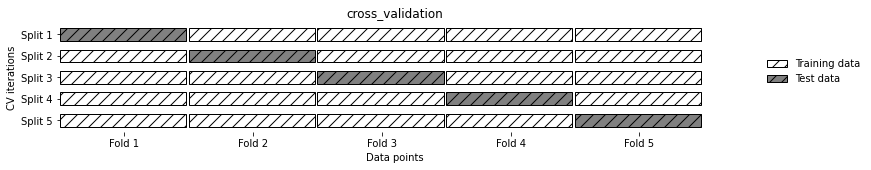

In [2]:
import mglearn
mglearn.plots.plot_cross_validation()

### 5.1.1 scikit-learnでの交差検証
* 交差検証はscikit-learnではmodel_selectionモジュールのcross_val_score関数として実装されている

In [4]:
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

iris=load_iris()
logreg=LogisticRegression(max_iter=10000)

scores=cross_val_score(logreg,iris.data,iris.target)    # デフォルトの分割数k=5
print("Cross-validation scores: {}".format(scores))

Cross-validation scores: [0.96666667 1.         0.93333333 0.96666667 1.        ]


* 交差検証の精度をまとめるには、一般に平均値を用いる

In [5]:
print("Average cross-validation score: {:.2f}".format(scores.mean()))

Average cross-validation score: 0.97


### 5.1.2 交差検証の利点
* 交差検証を使えば、すべてのデータが正確に1度だけテストに用いられるため、モデルはデータセットのすべてのサンプルに対して良い汎化性能を示さなければ、交差検証スコアとその平均を高くすることができない
* データを多数に分割すると、モデルの訓練データセットに対する敏感さを知ることができる（モデルが最悪の場合と最良の場合でどの程度の性能を示すかがわかる）
* データを単純に分割する場合と比較して、データをより効率的に使え、データが多ければ多いほどモデルが正確になる
* 最大の問題点は計算コスト（k個のモデルを訓練するため、単純な分割の場合に比べておよそk倍遅くなる）

### 5.1.3 層化k分割交差検証と他の戦略
* データセットをk個に分割する際に、データセットの先頭から1/kを取る方法は、いつもうまくいくとは限らない

In [6]:
from sklearn.datasets import load_iris
iris=load_iris()
print("Iris labels:\n{}".format(iris.target))

Iris labels:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


* 明らかに最初の1/3はクラス0、次の1/3はクラス1、最後の1/3はクラス2になっている
* このような場合に3分割交差検証にかけても、精度は0になってしまう
* 単純なk分割交差検証ではうまくいかないので、クラス分類器に関しては、scikit-learnはこの方法を用いず、層化k分割交差検証（stratified k-fold cross-validation）を用いる
* 層化交差検証では、各分割内でのクラスの比率が全体の比率と同じになるように分割する

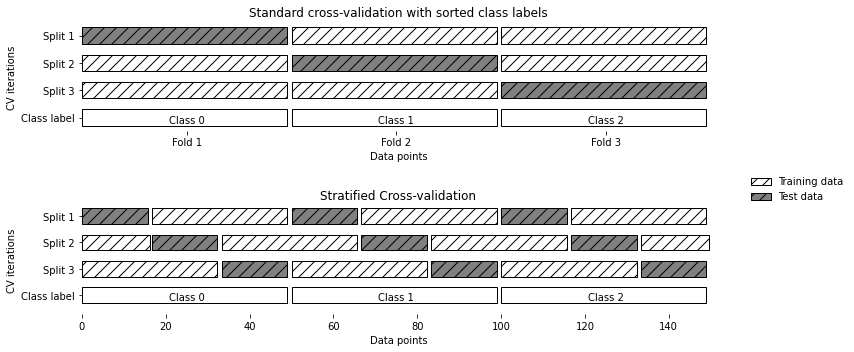

In [8]:
mglearn.plots.plot_stratified_cross_validation()

* 一般に、クラス分類機を評価するには、単純なk分割交差検証ではなく層化k分割交差検証を使ったほうが良い
* 回帰に関しては、scikit-learnは標準的なk分割交差検証をデフォルトで用いる（個々の分割が回帰ターゲットの分布を反映するようにすることもできるが、そのようにすることはあまりない）

#### 5.1.3.1 交差検証のより詳細な制御
* scikit-learnでは、cross_val_scoreのcvパラメータに交差検証分割器（cross-validation splitter）を与えることで、データ分割の方法をより詳細に制御することができる
* 殆どの場合は、回帰にはk分割交差検証、クラス分類には層化k分割交差検証というデフォルトの動作でうまくいく
* 別の人が行った結果を再現するために、クラス分類にk分割交差検証を用いる場合などは、以下の方法で行う

In [9]:
from sklearn.model_selection import KFold
kfold=KFold(n_splits=5)

print("Cross-validation scores:\n{}".format(cross_val_score(logreg,iris.data,iris.target,cv=kfold)))

Cross-validation scores:
[1.         1.         0.86666667 0.93333333 0.83333333]


* 3分割の層化されていない交差検証をirisデータセットに使うとひどいことになる

In [10]:
kfold=KFold(n_splits=3)
print("Cross-validation scores:\n{}".format(cross_val_score(logreg,iris.data,iris.target,cv=kfold)))

Cross-validation scores:
[0. 0. 0.]


* 何も学習できていない
* 層化して分割する代わりに、データをシャッフルしてサンプルがラベル順に並ばないようにする方法もある（KFoldのshuffleパラメータをTrueにする。random_stateも同時に設定したほうが良い）

In [11]:
kfold=KFold(n_splits=3,shuffle=True,random_state=0)
print("Cross-validation scores:\n{}".format(cross_val_score(logreg,iris.data,iris.target,cv=kfold)))

Cross-validation scores:
[0.98 0.96 0.96]


#### 5.1.3.2 1つ抜き交差検証
* k分割交差検証の個々の分割が1サンプルしかないものと考え、毎回テストセット中の1サンプルだけをテストセットとして検証する
* 大規模データでは非常に時間がかかるが、小さいデータセットに関しては、よりよい推定が可能になる

In [12]:
from sklearn.model_selection import LeaveOneOut
loo=LeaveOneOut()
scores=cross_val_score(logreg,iris.data,iris.target,cv=loo)
print("Number of iterations: ",len(scores))
print("Mean accuracy: {:.2f}".format(scores.mean()))

Number of iterations:  150
Mean accuracy: 0.97


#### 5.1.3.3 シャッフル分割交差検証
* シャッフル分割交差検証（shuffle-split cross validation）は非常に柔軟な交差検証手法
* 毎回train_size個の点を選び出して訓練セットとし、test_size個の（訓練セットとは重複しない）点を選び出してテストセットとする
* これをn_iter回繰り返す

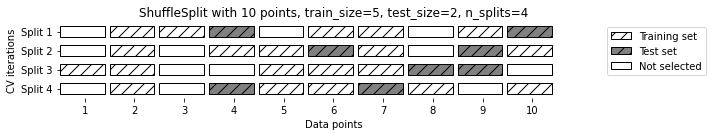

In [13]:
mglearn.plots.plot_shuffle_split()

In [14]:
# データセットの50%を訓練セットに、50%をテストセットにして10回分割を繰り返す例
from sklearn.model_selection import ShuffleSplit
shuffle_split=ShuffleSplit(test_size=.5,train_size=.5,n_splits=10)
scores=cross_val_score(logreg,iris.data,iris.target,cv=shuffle_split)
print("Cross-validation scores:\n{}".format(scores))

Cross-validation scores:
[0.93333333 0.96       0.96       0.92       0.98666667 0.97333333
 0.96       0.98666667 0.96       0.97333333]


* シャッフル交差検証を用いると、訓練セットとテストセットのサイズとは独立に繰り返し回数を制御できる
* train_sizeとtest_sizeの和が1にならないようにすることで、データの一部だけを用いるようにすることができる（サブサンプリングと呼ばれ、データセットが大きい場合に有効）
* ShuffleSplitにも層化バージョンがあり、StaratifiedShuffleSplitという名前がついている（クラス分類ではより信頼できる結果を得られる）

#### 5.1.3.4 グループ付き交差検証
* 顔画像から感情を認識するシステムを作る場合、クラス分類機の目的はデータセットに属していない人の感情を正確に予測すること
* クラス分類機の性能を評価するのに層化交差検証を用いた場合、同じ人が訓練セットにもテストセットにも含まれてしまう
* 訓練セットに含まれる人の感情を予測するのは、全く見たことのない人の感情を予測するより大幅に簡単になってしまう
* 新しい顔に対する汎化性能を正確に評価するには訓練セットとテストセットに含まれる人が重ならないようにしなければならない
* これを実現するためには、GroupFoldを用いる
* この関数は引数にgroupsという配列を取り、この配列には画像に写っている人を指定する（クラスラベルとは違う.この場合のクラスラベルは「嬉しい」など）
* 医療アプリケーションなどでは、同じ患者から得られた複数のサンプルを用いて、新しい患者に対する予測を行うのが目的
* 発話認識では、同じ話者による録音がデータセットに複数含まれている場合に。新しい話者の発話を認識することが目的


In [16]:
from sklearn.model_selection import GroupKFold
# 合成データセットを生成
X,y=make_blobs(n_samples=12,random_state=0)
# 最初の3サンプルが同じグループに次の4サンプルが同じグループに、、というようにする
groups=[0,0,0,1,1,1,1,2,2,3,3,3]
scores=cross_val_score(logreg,X,y,groups=groups,cv=GroupKFold(n_splits=3))
print("Cross-validation scores:\n{}".format(scores))

Cross-validation scores:
[0.75       0.6        0.66666667]


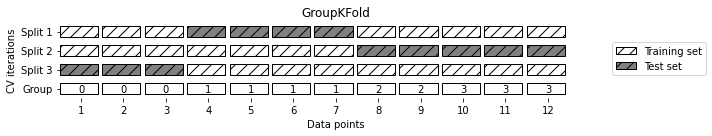

In [17]:
mglearn.plots.plot_group_kfold()

* 個々のグループは完全に訓練セットに入っているか、完全にテストセットに入っているかのどちらかになる

## 5.2 グリッドサーチ
* グリッドサーチは（grid search）、基本的にはパラメータのすべての組み合わせを試してみる方法

### 5.2.1 単純なグリッドサーチ
* RBFを用いたカーネル法を用いたSVMを使う場合、重要なパラメータとしてカーネルのバンド幅を表すgammaと、正則化パラメータCの2つがある
* 単純なグリッドサーチは、2つのパラメータに対するただのforループで実装することができる

In [18]:
# ナイーブなグリッドサーチの実装
from sklearn.svm import SVC 
X_train,X_test,y_train,y_test=train_test_split(iris.data,iris.target,random_state=0)
print("Size of trianing set: {}    size of test set: {}".format(X_train.shape[0],X_test.shape[0]))

best_score=0

for gamma in [0.001,0.01,0.1,1,10,100]:
    for C in [0.001,0.01,0.1,1,10,100]:
        # それぞれのパラメータの組み合わせに対してSVCを訓練
        svm=SVC(gamma=gamma,C=C)
        svm.fit(X_train,y_train)
        # SVCをテストセットで評価
        score=svm.score(X_test,y_test)
        # 良いスコアだったらスコアとパラメータを保存
        if score>best_score:
            best_score=score
            best_parameters={'C':C,'gamma':gamma}

print("Best score: {:.2f}".format(best_score))
print("Best parameters: {}".format(best_parameters))

Size of trianing set: 112    size of test set: 38
Best score: 0.97
Best parameters: {'C': 100, 'gamma': 0.001}


### 5.2.2 パラメータの過剰適合の危険性と検証セット
* テストデータをパラメータのチューニングに使ってしまったので、このテストデータをモデルの精度を評価するのには使えない
* この問題を解決する方法の1つは、データをもう一度分割し、3つのセットにする方法がある

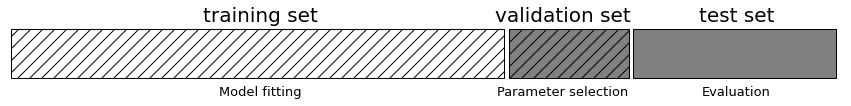

In [19]:
mglearn.plots.plot_threefold_split()

* 検証セットを用いて最良のパラメータを選択したら、そのパラメータを用いてモデルを再構築する
* この際に、訓練データだけでなく検証データも用いることで、可能な限りデータを有効に利用してモデルを構築することができる

In [20]:
from sklearn.svm import SVC 
# データを訓練＋検証セットとテストセットに分割する
X_trainval,X_test,y_trainval,y_test=train_test_split(iris.data,iris.target,random_state=0)
# 訓練＋検証セットを訓練セットと検証セットに分割する
X_train,X_valid,y_train,y_valid=train_test_split(X_trainval,y_trainval,random_state=1)
print("Size of trianing set: {}    size of validation set: {}    size of test set: {}".format(X_train.shape[0],X_valid.shape[0],X_test.shape[0]))

best_score=0

for gamma in [0.001,0.01,0.1,1,10,100]:
    for C in [0.001,0.01,0.1,1,10,100]:
        # それぞれのパラメータの組み合わせに対してSVCを訓練
        svm=SVC(gamma=gamma,C=C)
        svm.fit(X_train,y_train)
        # SVCを検証セットで評価
        score=svm.score(X_valid,y_valid)
        # 良いスコアだったらスコアとパラメータを保存
        if score>best_score:
            best_score=score
            best_parameters={'C':C,'gamma':gamma}

# 訓練セットと検証セットを用いてモデルを再構築し、テストセットで評価
svm=SVC(**best_parameters)
svm.fit(X_trainval,y_trainval)
test_score=svm.score(X_test,y_test)
print("Best score on validation set: {:.2f}".format(best_score))
print("Best parameters: ",best_parameters)
print("Test set score with best parameters: {:.2f}".format(test_score))

Size of trianing set: 84    size of validation set: 28    size of test set: 38
Best score on validation set: 0.96
Best parameters:  {'C': 10, 'gamma': 0.001}
Test set score with best parameters: 0.92


* 新しいデータに対する精度として主張できるのは、97%ではなく92%ということになる
* テストセットは分離しておき、最後の評価にだけ用いるようにしなければならない
* 厳密には、テストセットで2つ以上のモデルで評価して良い方を選ぶだけでも、モデルの精度を楽観的に見積もりすぎることになる

### 5.2.3 交差検証を用いたグリッドサーチ
* データを訓練セットと検証セットとテストセットに分割する方法は有用だが、データの実際の分割され方によって性能が大きく変動する
* 汎化性能をより良く見積もるためには、訓練セットと検証セットの分割を一度だけ行うのではなく、それぞれのパラメータの組み合わせに対して交差検証を行えば良い
* 交差検証を用いたグリッドサーチを交差検証と呼ぶ場合も多い

In [21]:
import numpy as np

best_score=0

for gamma in [0.001,0.01,0.1,1,10,100]:
    for C in [0.001,0.01,0.1,1,10,100]:
        # それぞれのパラメータの組み合わせに対してSVCを訓練
        svm=SVC(gamma=gamma,C=C)
        # 交差検証を行う
        scores=cross_val_score(svm,X_trainval,y_trainval,cv=5)
        # 交差検証精度の平均値を取る
        score=np.mean(scores)
        # 良いスコアだったらスコアとパラメータを保存
        if score>best_score:
            best_score=score
            best_parameters={'C':C,'gamma':gamma}

# 訓練セットと検証セットを用いてモデルを再構築し、テストセットで評価
svm=SVC(**best_parameters)
svm.fit(X_trainval,y_trainval)
test_score=svm.score(X_test,y_test)
print("Best score on validation set: {:.2f}".format(best_score))
print("Best parameters: ",best_parameters)
print("Test set score with best parameters: {:.2f}".format(test_score))

Best score on validation set: 0.97
Best parameters:  {'C': 10, 'gamma': 0.1}
Test set score with best parameters: 0.97


ValueError: The number of FixedLocator locations (21), usually from a call to set_ticks, does not match the number of ticklabels (36).

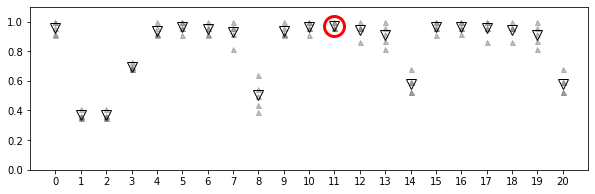

In [22]:
mglearn.plots.plot_cross_val_selection()

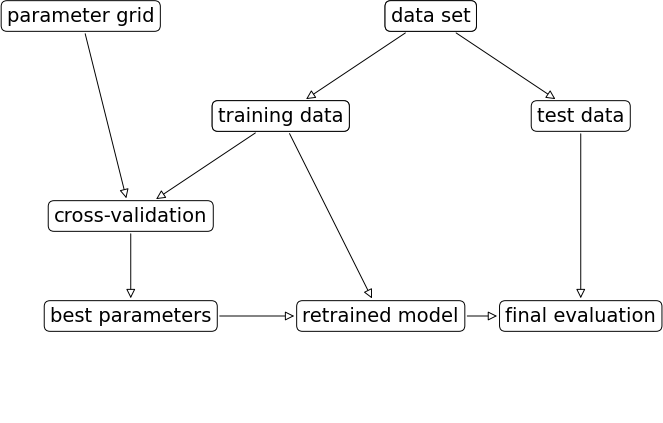

In [23]:
mglearn.plots.plot_grid_search_overview()

* 交差検証を用いたグリッドサーチは非常に一般的にパラメータチューニングに使われるので、scikit-learnではEstimatorの形でこの手法を実装したGridSearchCVクラスを提供している
* GridSearchCVクラスを使うには、まずディクショナリを用いて探索したいパラメータを指定する
* ディクショナリのキーはチューニングしたいパラメータ名で、キーに対応する値には試したい値を与える

In [24]:
param_grid={'C':[0.001,0.01,0.1,1,10,100],'gamma':[0.001,0.01,0.1,1,10,100]}
print("Parameter grid:\n{}".format(param_grid))

Parameter grid:
{'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}


In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC 
grid_search=GridSearchCV(SVC(),param_grid,cv=5)

X_train,X_test,y_train,y_test=train_test_split(iris.data,iris.target,random_state=0)

grid_search.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'gamma': [0.001, 0.01, 0.1, 1, 10, 100]})

* GridSearchCVオブジェクトのfitメソッドを呼び出すと、最適なパラメータ設定をサーチするだけでなく、交差検証で最も良いスコアだったパラメータを用いて、自動的に訓練セット全体に対して新しいモデルを学習してくれる
* 最適なパラメータの汎化性能を知りたければscoreメソッドをテストセットに対して呼び出せば良い

In [26]:
print("Test set score: {:.2f}".format(grid_search.score(X_test,y_test)))

Test set score: 0.97


* ここで重要なのが、このパラメータを選ぶのにテストセットを使わなかったということ
* 見つけたパラメータはbest_params_属性に、交差検証精度（そのパラメータ設定のさまざまな分割に対する平均精度）はbest_score_属性に格納されている

In [27]:
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross_validation score: {:.2f}".format(grid_search.best_score_))

Best parameters: {'C': 10, 'gamma': 0.1}
Best cross_validation score: 0.97


* 見つけた実際のモデルにアクセスして、係数あるいは特徴量の重要性を見たい場合は、best_estimator_属性を用いてアクセスすることで見ることができる
* grid_searchそのものにも、predictメソッドやscoreメソッドが実装されているので、予測を行ったりするために、best_estimator_属性を用いる必要はない

In [28]:
print("Best estimator:\n{}".format(grid_search.best_estimator_))

Best estimator:
SVC(C=10, gamma=0.1)


#### 5.2.3.1 交差検証の結果の解析
* 交差検証の結果を可視化すると、モデルの汎化性能がサーチパラメータに依存する様子を理解するのに役立つ
* グリッドサーチは計算量的に高価なので、比較的粗く小さいグリッドから始めるほうが良い
* グリッドサーチの結果はcv_results_属性に格納されている

In [30]:
import pandas as pd 
# DataFrameへ変換
results=pd.DataFrame(grid_search.cv_results_)
# 最初の5行を表示
display(results.head())

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001078,0.000338,0.000634,0.000258,0.001,0.001,"{'C': 0.001, 'gamma': 0.001}",0.347826,0.347826,0.363636,0.363636,0.409091,0.366403,0.022485,22
1,0.001455,0.000328,0.000783,0.000308,0.001,0.01,"{'C': 0.001, 'gamma': 0.01}",0.347826,0.347826,0.363636,0.363636,0.409091,0.366403,0.022485,22
2,0.003608,0.003480,0.001025,0.000649,0.001,0.1,"{'C': 0.001, 'gamma': 0.1}",0.347826,0.347826,0.363636,0.363636,0.409091,0.366403,0.022485,22
3,0.001225,0.000206,0.000596,0.000127,0.001,1,"{'C': 0.001, 'gamma': 1}",0.347826,0.347826,0.363636,0.363636,0.409091,0.366403,0.022485,22
4,0.000959,0.000161,0.000704,0.000537,0.001,10,"{'C': 0.001, 'gamma': 10}",0.347826,0.347826,0.363636,0.363636,0.409091,0.366403,0.022485,22


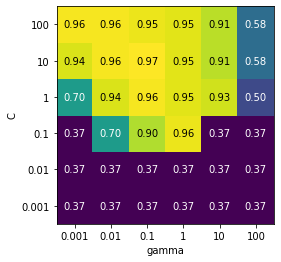

In [31]:
scores=np.array(results.mean_test_score).reshape(6,6)

# 平均交差検証スコアのプロット
mglearn.tools.heatmap(scores,xlabel='gamma',xticklabels=param_grid['gamma'],ylabel='C',yticklabels=param_grid['C'],cmap="viridis")

* SVCはパラメータの設定に敏感であることがわかる
* 良い性能を得るためにはパラメータの設定が非常に重要（SVCではCとgammaの双方のパラメータが重要）
* パラメータのレンジは十分に大きくしなければならない（それぞれのパラメータの最良値がプロットの端にならないようにすべき）

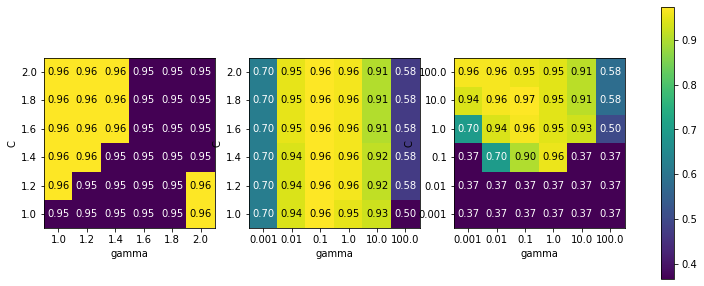

In [33]:
import matplotlib.pyplot as plt

fig,axes=plt.subplots(1,3,figsize=(13,5))
param_grid_linear={'C':np.linspace(1,2,6),'gamma':np.linspace(1,2,6)}
param_grid_one_log={'C':np.linspace(1,2,6),'gamma':np.logspace(-3,2,6)}
param_grid_range={'C':np.logspace(-3,2,6),'gamma':np.logspace(-3,2,6)}

for param_grid,ax in zip([param_grid_linear,param_grid_one_log,param_grid_range],axes):
    grid_search=GridSearchCV(SVC(),param_grid,cv=5)
    grid_search.fit(X_train,y_train)
    scores=grid_search.cv_results_['mean_test_score'].reshape(6,6)

    # 平均交差検証精度をプロット
    scores_image=mglearn.tools.heatmap(scores,xlabel='gamma',ylabel='C',xticklabels=param_grid['gamma'],yticklabels=param_grid['C'],cmap="viridis",ax=ax)

plt.colorbar(scores_image,ax=axes.tolist())

* ↑サーチグリッドが不適切な場合のヒートマップによる可視化
* パラメータグリッドを交差検証スコアを用いてチューニングすることはなんの問題もないが、最後のテストセットを使ってパラメータレンジを探索してはいけない

#### 5.2.3.2 グリッドではないサーチ空間
* GridSearchCVはparam_gridとしてディクショナリのリストを受け付ける用に作られている
* リスト中の個々のリストが独立したグリッドに展開される

In [34]:
param_grid=[
    {'kernel':['rbf'],'C':[0.001,0.01,0.1,1,10,100],'gamma':[0.001,0.01,0.1,1,10,100]},
    {'kernel':['linear'],'C':[0.001,0.01,0.1,1,10,100]}
]
print("List of grid:\n{}".format(param_grid))

List of grid:
[{'kernel': ['rbf'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}, {'kernel': ['linear'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]}]


In [36]:
grid_search=GridSearchCV(SVC(),param_grid,cv=5)
grid_search.fit(X_train,y_train)
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Best parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Best cross-validation score: 0.97


In [37]:
results=pd.DataFrame(grid_search.cv_results_)
display(results.T)

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
mean_fit_time,0.001455,0.001545,0.001463,0.001254,0.001246,0.00146,0.001859,0.001159,0.00091,0.001024,...,0.000907,0.000934,0.001873,0.001269,0.000987,0.001359,0.00384,0.000887,0.001095,0.001097
std_fit_time,0.001295,0.000559,0.000343,0.000368,0.000304,0.000662,0.002176,0.000613,0.000233,0.000276,...,0.000417,0.000368,0.001941,0.000402,0.00022,0.000916,0.006012,0.000241,0.000402,0.000434
mean_score_time,0.000616,0.000763,0.000943,0.001292,0.000775,0.000704,0.000501,0.000445,0.000479,0.000603,...,0.000967,0.000332,0.000564,0.000587,0.000479,0.002282,0.000379,0.00113,0.002139,0.00048
std_score_time,0.00041,0.000032,0.000365,0.000891,0.000236,0.000239,0.000127,0.000032,0.000118,0.000159,...,0.001046,0.000032,0.000189,0.000174,0.0001,0.004005,0.000096,0.00143,0.003445,0.000112
param_C,0.001,0.001,0.001,0.001,0.001,0.001,0.01,0.01,0.01,0.01,...,100,100,100,100,0.001,0.01,0.1,1,10,100
param_gamma,0.001,0.01,0.1,1,10,100,0.001,0.01,0.1,1,...,0.1,1,10,100,NaN,NaN,NaN,NaN,NaN,NaN
param_kernel,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,...,rbf,rbf,rbf,rbf,linear,linear,linear,linear,linear,linear
params,"{'C': 0.001, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 1, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 10, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 100, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 1, 'kernel': 'rbf'}",...,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 100, 'gamma': 1, 'kernel': 'rbf'}","{'C': 100, 'gamma': 10, 'kernel': 'rbf'}","{'C': 100, 'gamma': 100, 'kernel': 'rbf'}","{'C': 0.001, 'kernel': 'linear'}","{'C': 0.01, 'kernel': 'linear'}","{'C': 0.1, 'kernel': 'linear'}","{'C': 1, 'kernel': 'linear'}","{'C': 10, 'kernel': 'linear'}","{'C': 100, 'kernel': 'linear'}"
split0_test_score,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,...,1.0,0.956522,0.869565,0.521739,0.347826,0.869565,1.0,1.0,1.0,0.956522
split1_test_score,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,...,0.956522,0.956522,0.913043,0.521739,0.347826,0.869565,0.913043,0.956522,1.0,0.956522


#### 5.2.3.3 異なる交差検証手法を用いたグリッドサーチ
* GridSearchCVはcross-val_scoreと同様に、デフォルトではクラス分類には層化k分割交差検証を、回帰にはk分割交差検証を用いる
* 交差検証の分割器をcvパラメータにわたすことができるので、訓練セットと検証セットとの分割を一度だけ行いたい（データセットが非常に大きい、計算に時間がかかるなど）場合は、ShuffleSplitもしくはStratifiedShuffleSplitを用いて、n_iter=1にすると良い

#### 5.2.3.4 ネストした交差検証
* 訓練セットとテストセットの分割が一度だけだと、その一回の分割に結果が依存してしまうため、不安定になる可能性がある
* もとのデータを訓練セットとテストセットに一度だけ分けるのではなく、交差検証で何度も分割することを考える（ネストした交差検証）
* ネストした交差検証では、外側にループを設け、そこでデータを訓練セットとテストセットに分割し、それぞれの分割に対してグリッドサーチを実行する
* ここで、外側ループのそれぞれの分割に対して最良のパラメータの組み合わせは異なるかもしれない
* それぞれの分割に対して、最良のセッティングでテストセットを評価した結果が報告される
* この手続きの結果はスコアのリストであり、このモデルのグリッドから見つけた最適なパラメータによる汎化性能を表す
* 新しいデータに対して利用できるモデルを与えるわけではないので、ネストした交差検証は未来のデータに適用するための予測モデルを探すために用いられることはほとんどないが、あるモデルのあるデータセットに対する性能の評価には有用

In [38]:
scores=cross_val_score(GridSearchCV(SVC(),param_grid,cv=5),iris.data,iris.target,cv=5)
print("Cross-validation scores: ",scores)
print("Mean cross-validation score: ",scores.mean())

Cross-validation scores:  [0.96666667 1.         0.9        0.96666667 1.        ]
Mean cross-validation score:  0.9666666666666668


* このネストした交差検証の結果は「SVCはirisデータセットに対して交差検証精度の平均で98%を達成することができる」ことを表している（それ以上でもそれ以下でもない）
* ネストした交差検証は計算量的に非常に高価
* 内側と外側のループに対して任意の交差検証手法の組み合わせを用いることができる

In [43]:
# ネストした交差検証をforループで表したコード
def nested_cv(X,y,inner_cv,outer_cv,Classifier,parameter_grid):
    outer_scores=[]
    # 外側の交差検証による個々の分割に対するループ
    # (splitメソッドはインデックスを返す)
    for training_samples,test_samples in outer_cv.split(X,y):
        # 内側の交差検証を用いて最良のパラメータ設定を見つける
        best_params={}
        best_score=-np.inf
        # 個々のパラメータ設定に対してループ
        for parameters in parameter_grid:
            # 内側の分割に対するスコアを格納
            cv_scores=[]
            # 内側の交差検証のループ
            for inner_train,inner_test in inner_cv.split(X[training_samples],y[training_samples]):
                # 与えられたパラメータと訓練セットでクラス分類器を訓練
                clf=Classifier(**parameters)
                clf.fit(X[inner_train],y[inner_train])
                # 内側のテストセットを評価
                score=clf.score(X[inner_test],y[inner_test])
                cv_scores.append(score)
            # 内部の分割に対するスコアの平均を算出
            mean_score=np.mean(cv_scores)
            if mean_score>best_score:
                # これまでのものよりも良ければパラメータを記憶
                best_score=mean_score
                best_params=parameters
        # 最良のパラメータセットと外側の訓練セットを用いてクラス分類機を構築
        clf=Classifier(**best_params)
        clf.fit(X[training_samples],y[training_samples])
        # 評価する
        outer_scores.append(clf.score(X[test_samples],y[test_samples]))
    return np.array(outer_scores)

In [44]:
from sklearn.model_selection import ParameterGrid,StratifiedKFold
scores=nested_cv(iris.data,iris.target,StratifiedKFold(5),StratifiedKFold(5),SVC,ParameterGrid(param_grid))
print("Cross-validation scores: {}".format(scores))

Cross-validation scores: [0.96666667 1.         0.96666667 0.96666667 1.        ]


#### 5.2.3.5 交差検証とグリッドサーチの並列化
* たくさんのパラメータの組み合わせに対して大規模データセットを用いてグリッドサーチを行うには膨大な計算量が必要になるが、この操作は単純並列（embarrassingly parallel）でもある
* つまり、特定の交差検証分割に対する特定のパラメータ設定でのモデル構築は、他のパラメータ設定や分割に対して完全に独立に実行できるため、CPUコアやクラスタを用いての並列化ができる
* GridSearchCVとcross_val_scoreでは、パラメータn_jobsに利用したいコア数を設定することで、複数のコアを利用することができる（n_jobs=-1で利用できるすべてのコアを使用する）
* ただし、scikit-learnではネストした並列実行はサポートされていない（モデルでn_jobsオプションを使っていたらGridSearchCVでは使えない）
* データセットやモデルが非常に大きい場合、たくさんのコアを使おうとするとメモリを使いすぎる場合があるため、大規模なモデルを並列に構築する場合はメモリを監視する必要がある
* グリッドサーチと交差検証をクラスタの複数マシンを用いて並列化することも可能だが、scikit-learnには実装されていない
* IPythonの並列化フレームワークを使って並列グリッドサーチを実装することはできるが、パラメータセットに対してforループを書く必要がある
* spark-sklearn(https://github.com/databricks/spark-sklearn)パッケージを用いれば、グリッドサーチをSparkクラスタ上で実行することができる

## 5.3 評価基準とスコア

* クラス分類性能を精度（正確に分類されたサンプルの割合）で、回帰性能をR^2で評価してきたが、これらはあるデータに対する教師あり学習モデルの性能を1つの数値にまとめるためのさまざまな手法のうちの2例に過ぎない
* モデルの選択やパラメータのチューニングの際に適切な基準を用いる事が重要

### 5.3.1 最終的な目標を見失わないこと
* 実際に機械学習を利用する際には、正確な予測をすることだけに興味があるわけではなく、より大きな意思決定の過程の中でその予測を用いる場合が多い
* 機械学習の基準を選ぶ前に、そのアプリケーションの高レベルでの目的（ビジネス評価基準）を考える必要がある
* 機械学習アプリケーションに対して特定のアルゴリズムを選択した結果はビジネスインパクトと呼ばれる
* 高レベルでの目標とは、例えば「交通事故を防ぐ」、「病院への入院回数をへらす」、「多くのユーザーを獲得する」、「ユーザーに多くのお金を使わせる」など
* 特定のモデルのビジネスインパクトを評価するには、それを実際の運用環境に置かなければならない場合があるため簡単ではない
* 多くの場合、より簡単に計算できる評価基準を使って、何らかの代用となる評価指標を見つけなければならない
* しかし、これが単なる代用にすぎないことに留意し、評価が可能な基準のうち本来のビジネスゴールに最も近いものを見つけるようにしなければならない
* 基準はあるモデルと別のモデルを比較した際のビジネスインパクトを捉えたものでなければならない

### 5.3.2 2クラス分類における基準
* 2クラス分類の場合には、2つのクラスを陽性クラスと陰性クラスと呼び、探しているものを陽性と呼ぶ

#### 5.3.2.1 エラーの種類
* 精度は予測性能の尺度しては、間違えた回数に我々が興味を持つ情報がすべては含まれていないため、良くない場合がしばしばある
* 間違った陽性との判断を偽陽性（false positive: FP）と呼ぶ（統計学ではタイプⅠエラーと呼ぶ）
* 誤った陰性との判断を偽陰性（false negative: FN）と呼ぶ（統計学ではタイプⅡエラーと呼ぶ）
* 偽陽性と偽陰性が同じ重みであることはほとんどない


#### 5.3.2.2 偏ったデータセット
* エラーのタイプは、2つのクラスの一方がもう一方よりもずっと多い場合に重要になる
* 例としては、クリックスルーのように、99%が「クリックされない」クラスになり、1%が「クリックされる」クラスになるような場合
* 一方のクラスが他方のクラスよりもずっと多いようなデータセットを偏ったデータセット（imbalanced datasets）もしくは偏ったクラスのデータセット（datasets with imbalanced classes）と呼ぶ

In [47]:
from sklearn.datasets import load_digits

digits=load_digits()
y=digits.target==9  # 0から9のうち、9のみTrueにする
print(y)

X_train,X_test,y_train,y_test=train_test_split(digits.data,y,random_state=0)

[False False False ... False  True False]


* 9以外を予測するようにして、精度が役に立たないことを確かめてみる

In [49]:
from sklearn.dummy import DummyClassifier
dummy_majority=DummyClassifier(strategy='most_frequent').fit(X_train,y_train)
pred_most_frequent=dummy_majority.predict(X_test)
print("Unique predicted labels: {}".format(np.unique(pred_most_frequent)))
print("Test score: {:.2f}".format(dummy_majority.score(X_test,y_test)))

Unique predicted labels: [False]
Test score: 0.90


* 一方を常に予測しているだけで精度は90%を達成してしまうので役に立たない

In [50]:
from sklearn.tree import DecisionTreeClassifier
tree=DecisionTreeClassifier(max_depth=2).fit(X_train,y_train)
pred_tree=tree.predict(X_test)
print("Test score: {:.2f}".format(tree.score(X_test,y_test)))

Test score: 0.92


* DecisionTreeClassifierは常に同じ答えを返す予測器よりも少し良いだけだが、この結果が意味するのは、DecisionTreeClassifierの使い方を間違えたか、精度が良い基準ではないのか、どちらかを意味する

In [52]:
from sklearn.linear_model import LogisticRegression

dummy=DummyClassifier().fit(X_train,y_train)
pred_dummy=dummy.predict(X_test)
print("dummy score: {:.2f}".format(dummy.score(X_test,y_test)))

logreg=LogisticRegression(C=0.1,max_iter=10000).fit(X_train,y_train)
pred_logreg=logreg.predict(X_test)
print("logreg score: {:.2f}".format(logreg.score(X_test,y_test)))

dummy score: 0.90
logreg score: 0.98


* ランダムな分類器ですら精度90%を達成しているため、偏ったデータセットに対する予測性能を定量化する基準として、精度は不適切といえる

#### 5.3.2.3 混同行列
* 2クラス分類の評価結果を表現する方法で、最も包括的な方法の1つとして混同行列（confusion matrix）がある

In [55]:
from sklearn.metrics import confusion_matrix

confusion=confusion_matrix(y_test,pred_logreg)
print("Confusion matrix:\n{}".format(confusion))

Confusion matrix:
[[402   1]
 [  6  41]]


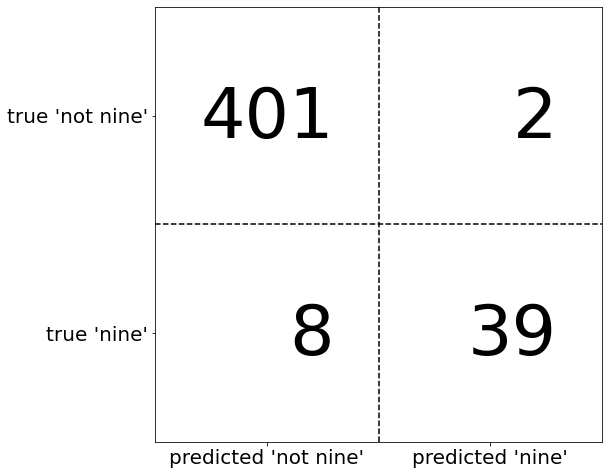

In [56]:
mglearn.plots.plot_confusion_matrix_illustration()

* 混同行列の主対角成分の要素は、正確にクラス分類されたサンプルの個数を示し、それ以外の要素は、実際とは違うクラスに分類されたサンプルの個数を示す
* すべてのエントリを埋めるために、陽性クラスで正しく分類されたサンプルを真陽性（true positive: TP）、陰性クラスで正しく分類されたサンプルを真陰性（true negative: TN）と呼ぶ

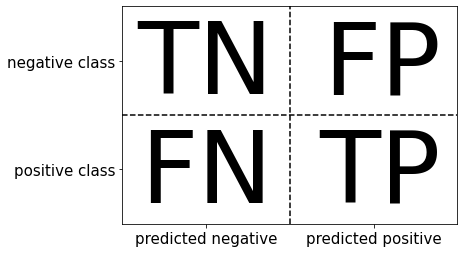

In [57]:
mglearn.plots.plot_binary_confusion_matrix()

In [58]:
print("Most frequency class:")
print(confusion_matrix(y_test,pred_most_frequent))
print("\nDummy model:")
print(confusion_matrix(y_test,pred_dummy))
print("\nDecision tree:")
print(confusion_matrix(y_test,pred_tree))
print("\nLogistic Regeression:")
print(confusion_matrix(y_test,pred_logreg))

Most frequency class:
[[403   0]
 [ 47   0]]

Dummy model:
[[403   0]
 [ 47   0]]

Decision tree:
[[390  13]
 [ 24  23]]

Logistic Regeression:
[[402   1]
 [  6  41]]


* 決定木とロジスティック回帰だけがまともな結果を返しており、その中でも、ロジスティック回帰のほうが決定木よりすべての面で良いということがわかる


##### 精度との関係
$$
精度=\mathrm{\dfrac{TP+TN}{TP+TN+FP+FN}}
$$

##### 適合率、再現率、f-値
* 混同行列をまとめる方法は他にもたくさんあり、最もよく使われるのは、適合率と再現率
* 適合率（precision,PPV: positive predictive value（陽性的中率））:   
    陽性と予測されたもののうち、実際に陽性である割合（偽陽性の数を制限したい場合に性能基準として用いられる.）
$$
適合率=\mathrm{\dfrac{TP}{TP+FP}}
$$
* 再現率（recall,感度（sensitivity）,ヒット率（hit rate）,真陽性率（true positive rate: TPR））:  
     陽性サンプルのうち、陽性と予測されたものの割合（すべての陽性サンプルを陽性と判断する必要がある場合、つまり偽陰性を避けることが重要な場合に用いる）
$$
再現率=\mathrm{\dfrac{TP}{TP+FN}}
$$
* 再現率の最適化と適合率の最適化はトレードオフの関係にある
* f-値（f-measure）: 
    適合率と再現率の調和平均
$$
\mathrm{F=2\times\dfrac{適合率\times再現率}{適合率+再現率}}
$$

In [61]:
from sklearn.metrics import f1_score
print("f1 score most frequent: {:.2f}".format(f1_score(y_test,pred_most_frequent)))
print("f1 score dummy: {:.2f}".format(f1_score(y_test,pred_dummy)))
print("f1 score tree: {:.2f}".format(f1_score(y_test,pred_tree)))
print("f1 score logistiv regression: {:.2f}".format(f1_score(y_test,pred_logreg)))

f1 score most frequent: 0.00
f1 score dummy: 0.00
f1 score tree: 0.55
f1 score logistiv regression: 0.92


* ダミー2つと決定木による予測が峻別できている（精度だけでは明らかでなかった）
* f-値を使うと、予測性能を再び一つの値で扱うことができる
* 適合率、再現率、f-値をまとめた包括的なレポートを得るには、便利なclassification_report関数を用いれば良い

In [62]:
from sklearn.metrics import classification_report
print(classification_report(y_test,pred_most_frequent,target_names=["not nine","nine"]))

              precision    recall  f1-score   support

    not nine       0.90      1.00      0.94       403
        nine       0.00      0.00      0.00        47

    accuracy                           0.90       450
   macro avg       0.45      0.50      0.47       450
weighted avg       0.80      0.90      0.85       450



/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


* classification_report関数は、クラス（この場合は真と偽）ごとに、そのクラスを陽性とした場合の適合率と再現率、f-値を出力する
* 陽性クラスを多数派の「9以外」にすると、classification_reportの出力によると、most_frequencyでもf-値が0,94になってしまう
* さらに、すべてを「9以外」に分類するので、再現率は1になる
* f-値の隣の最後の列には個々のクラスの支持度（support、そのクラスの実際のサンプルの個数）が出力される
* クラス分類レポートの最後の行は、（各クラスのサンプルの個数で）重み付けした平均値を表す

In [63]:
print(classification_report(y_test,pred_dummy,target_names=["not nine","nine"]))

              precision    recall  f1-score   support

    not nine       0.90      1.00      0.94       403
        nine       0.00      0.00      0.00        47

    accuracy                           0.90       450
   macro avg       0.45      0.50      0.47       450
weighted avg       0.80      0.90      0.85       450



/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [65]:
print(classification_report(y_test,pred_tree,target_names=["not nine","nine"]))

              precision    recall  f1-score   support

    not nine       0.94      0.97      0.95       403
        nine       0.64      0.49      0.55        47

    accuracy                           0.92       450
   macro avg       0.79      0.73      0.75       450
weighted avg       0.91      0.92      0.91       450



In [64]:
print(classification_report(y_test,pred_logreg,target_names=["not nine","nine"]))

              precision    recall  f1-score   support

    not nine       0.99      1.00      0.99       403
        nine       0.98      0.87      0.92        47

    accuracy                           0.98       450
   macro avg       0.98      0.93      0.96       450
weighted avg       0.98      0.98      0.98       450



* どちらのクラスを陽性とするかで、値が大きく変わってしまうことがわかる
* すべての値をあわせてみると、かなり正確な様子がつかめ、ロジスティック回帰の優位性が明らかになる

#### 5.3.2.4 不確実性を考慮に入れる
* 殆どのクラス分類器には、予測の不確実性を評価するためのdecision_functionメソッドもしくはpredict_probaメソッドが用意されている
* 予測を行うことは、decision_functionやpredict_probaの出力を固定したスレッショルドで分けることに相当する（スレッショルドはdecision_functionは0、predict_probaは0.5）


In [66]:
from mglearn.datasets import make_blobs
X,y=make_blobs(n_samples=(400,50),cluster_std=[7.0,2],random_state=22)
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=0)
svc=SVC(gamma=.05).fit(X_train,y_train)

/usr/local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function make_blobs is deprecated; Please import make_blobs directly from scikit-learn
  warnings.warn(msg, category=FutureWarning)


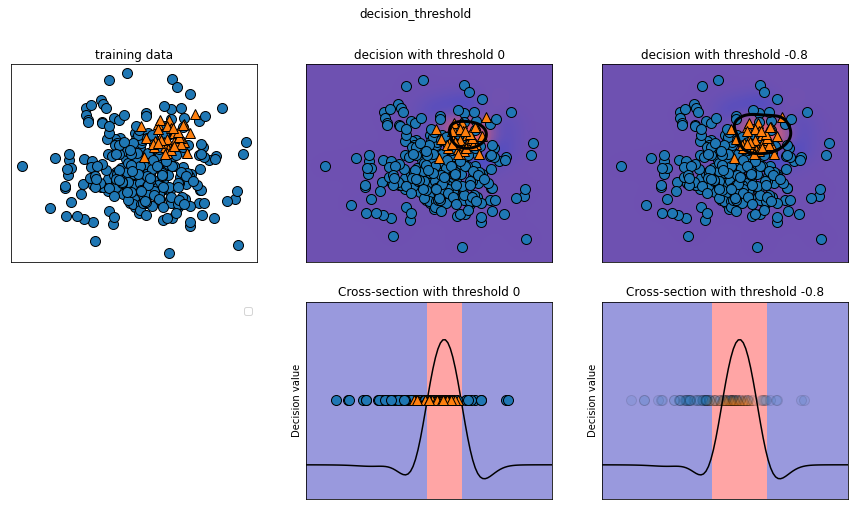

In [67]:
mglearn.plots.plot_decision_threshold()

* 400点が陰性クラスで50点が陽性クラスの偏った分類タスク
* プロット中の黒い円はdecision_functionの値がちょうど0になる場所を表す（円の内側は陽性、外側は陰性と分類される）

In [68]:
print(classification_report(y_test,svc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      0.89      0.93       104
           1       0.35      0.67      0.46         9

    accuracy                           0.88       113
   macro avg       0.66      0.78      0.70       113
weighted avg       0.92      0.88      0.89       113



* クラス0が遥かに多いので、クラス分類器はクラス0を正しく分類することに集中してしまい、少ないクラス1の識別がうまくいかない
* クラス1の再現性を高めることが重要とした場合、偽陽性（間違ってクラス1と判定すること）が増えても構わないから、より多くの真陽性を得たい
* 決定スレッショルドを0から動かすことで、クラス1の再現率が高くなるように予測を調整することができる（デフォルトではdecision_functionの値が0以上であればクラス1に分類される）
* ここでは、より多くのデータポイントがクラス1に分類されるようにしたいので、スレッショルドを小さくする

In [69]:
y_pred_lower_threshold=svc._decision_function(X_test)>-.8
print(classification_report(y_test,y_pred_lower_threshold))

              precision    recall  f1-score   support

           0       1.00      0.82      0.90       104
           1       0.32      1.00      0.49         9

    accuracy                           0.83       113
   macro avg       0.66      0.91      0.69       113
weighted avg       0.95      0.83      0.87       113



* 予想通り、クラス1の再現率は向上し、適合率は下がった
* 適合率と再現率のどちらか一方を重視したい場合、もしくはデータが大幅に偏っている場合、一番簡単に良い結果を得るには決定スレッショルドを変更すること
* ここでは説明のためにテストセットの結果を用いてスレッショルドを設定したが、実際にはテストセットを使ってはいけない（検証セットを用いるか、交差検証を使うようにする）
* predict_probaの出力は0から1の範囲に固定されていて、確率を表している（デフォルトは0.5、つまり50%以上「確か」だと判断すればその点は陽性クラスに分類される）
* スレッショルドを大きくすれば、陽性に分類するには、より「確か」と判断していなければならなくなる
* 較正（calibration）されたモデルは、確信度に対して正確な基準を提供する
* 較正については下記を参照  
https://www.cs.cornell.edu/~alexn/papers/calibration.icml05.crc.rev3.pdf

#### 5.3.2.5 適合率-再現率カーブとROCカーブ
* あるクラスに対して特定の再現率や適合率が決められたら、それに応じてスレッショルドを決めることができる
* 例えば再現率90%のような特定のターゲットを満たすスレッショルドを設定することは常に可能だが、難しいのはこのようなスレッショルドでも適切な適合率を保てるようなモデルを開発すること
* 再現率90%のように、クラス分類器に要請を設定することを、しばしば作動ポイント（operating point）の設定と呼ぶ
* 作動ポイントを固定することは、ビジネス環境においては性能を顧客や組織内の他のグループに対して保証することになる
* 新しいモデルを開発する際には、すべての可能なスレッショルド、すなわちすべての可能な適合率と再現率の組み合わせを同時に見ることが役に立つ
* これには適合率-再現率カーブ（precision-recall curve）と呼ばれるものを用いる
* precision_recall_curve関数は、すべての可能なスレッショルドに対する適合率と再現率の値のリストをソートして返すので、プロットすることができる

In [70]:
from sklearn.metrics import precision_recall_curve
precision,recall,thresholds=precision_recall_curve(y_test,svc._decision_function(X_test))

/usr/local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function make_blobs is deprecated; Please import make_blobs directly from scikit-learn
  warnings.warn(msg, category=FutureWarning)


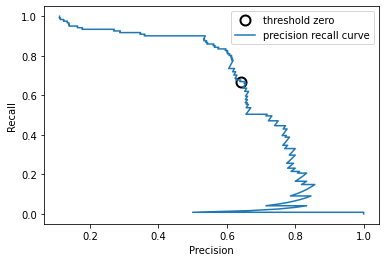

In [71]:
# カーブがなめらかになるようにデータポイントを増やす
X,y=make_blobs(n_samples=(4000,500),cluster_std=[7.0,2],random_state=22)
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=0)
svc=SVC(gamma=.05).fit(X_train,y_train)
precision,recall,thresholds=precision_recall_curve(y_test,svc.decision_function(X_test))
# ゼロに最も近いスレッショルドを探す
close_zero=np.argmin(np.abs(thresholds))
plt.plot(precision[close_zero],recall[close_zero],'o',markersize=10,label='threshold zero',fillstyle='none',c='k',mew=2)
plt.plot(precision,recall,label='precision recall curve')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.legend(loc='best')

* カーブが右上の角に近ければ近いほど、適合率が高く、同時に再現率も高いので、良いクラス分類器であると言える
* このモデルでは、適合率0.5より大きい領域では、適合率を少し上げると再現率が大きく低下する
* 得意とするカーブの部分、すなわち作動ポイントは、クラス分類器によって異なる

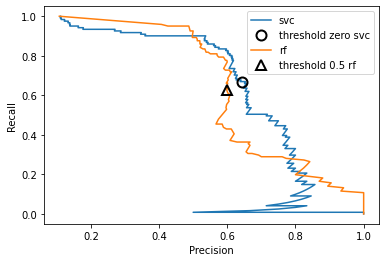

In [72]:
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(n_estimators=100,random_state=0,max_features=2)
rf.fit(X_train,y_train)

# RandomForestClassifierにはpredict_probaはあるが、decision_functionがない
precision_rf,recall_rf,thresholds_rf=precision_recall_curve(y_test,rf.predict_proba(X_test)[:,1])

plt.plot(precision,recall,label='svc')

plt.plot(precision[close_zero],recall[close_zero],'o',markersize=10,label='threshold zero svc',fillstyle='none',c='k',mew=2)

plt.plot(precision_rf,recall_rf,label='rf')

close_default_rf=np.argmin(np.abs(thresholds_rf-0.5))
plt.plot(precision_rf[close_default_rf],recall_rf[close_default_rf],'^',c='k',markersize=10,label='threshold 0.5 rf',fillstyle='none',mew=2)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.legend(loc='best')

* 適合率-再現率カーブを比較してみると、極端なケース、つまり非常に高い再現率や非常に高い適合率が要求される場合には、ランダムフォレストの性能が良い
* その中間（再現率が0.7あたり）では、SVMのほうが性能が良い
* f1-値だけを見て全体の性能を比較していたのでは、このような微妙な部分を見過ごしてしまう（f1-値はデフォルトのスレッショルドで与えられる1点を表しているに過ぎない）

In [73]:
print("f1_score of random forest: {:.3f}".format(f1_score(y_test,rf.predict(X_test))))
print("f1_score of svc: {:.3f}".format(f1_score(y_test,svc.predict(X_test))))

f1_score of random forest: 0.610
f1_score of svc: 0.656


* 適合率-再現率カーブを要約する方法の一つが、カーブ下の領域を積分する平均適合率（average precision）
* average_precision_scoreには、predictの結果ではなく、decision_functionもしくはpredict_probaの結果を渡す必要がある（適合率-再現率カーブから計算して複数のスレッショルドを考えるため）

In [74]:
from sklearn.metrics import average_precision_score
ap_rf=average_precision_score(y_test,rf.predict_proba(X_test)[:,1])
ap_svc=average_precision_score(y_test,svc._decision_function(X_test))
print("Average precision of random forest: {:.3f}".format(ap_rf))
print("Average precision of svc: {:.3f}".format(ap_svc))

Average precision of random forest: 0.660
Average precision of svc: 0.666


* すべての可能なスレッショルドに対して平均を取ると、ランダムフォレストとSVCの結果はだいたい同じだが、ランダムフォレストのほうが少しだけ良いという結果になる
* これはf1_scoreで得た結果とは大きく異なる
* 平均適合率は0から1までのカーブの下の領域なので、平均適合率の値は0（最悪値）から1（最良値）までとなる
* decision_functionにランダムな値を返すクラス分類機では、平均適合率の値はデータセット中の陽性サンプルの割合と同じになる

#### 5.3.2.6 受信者動作特性（ROC）とAUC
* さまざまなスレッショルドにおけるクラス分類機の挙動を解析するためのよく使われているもう一つの道具として、受信者特性カーブ（receiver operating characteristics curve）略してROCカーブがある
* 適合率-再現率カーブと同様に、ROCカーブは与えられたクラス分類機のすべてのスレッショルドを考慮するが、適合率と再現率の代わりに、偽陽性率（false positive rate: FPR）を真陽性率（true positive rate: TPR,再現率の別名）に対してプロットする
$$
\mathrm{FPR=\dfrac{FP}{FP+TN}}
$$
* 偽陽性率（FPR）はすべての陰性サンプルのうち、誤って陽性と予測された陰性サンプルの割合

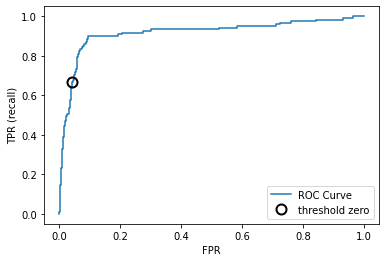

In [75]:
from sklearn.metrics import roc_curve
fpr,tpr,thresholds=roc_curve(y_test,svc._decision_function(X_test))

plt.plot(fpr,tpr,label='ROC Curve')
plt.xlabel('FPR')
plt.ylabel('TPR (recall)')
# 0に最も近いスレッショルドを探す
close_zero=np.argmin(np.abs(thresholds))
plt.plot(fpr[close_zero],tpr[close_zero],'o',markersize=10,label='threshold zero',fillstyle='none',c='k',mew=2)
plt.legend(loc=4)

* ROCカーブにおいては、理想的な点は左上に近い点（低い偽陽性率を保ちながら高い再現率を達成する）
* このカーブからは、デフォルトのスレッショルド0と比較すると、FPRをわずかに増やすだけで、遥かに高い再現率（およそ0.9）を達成できることがわかる
* スレッショルドを選択する際にはテストセットではなく検証セットをつかうこと

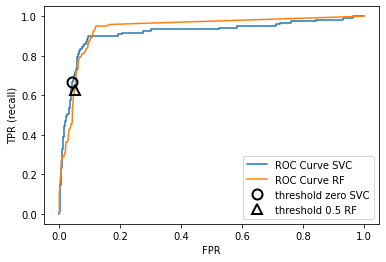

In [78]:
from sklearn.metrics import roc_curve
fpr_rf,tpr_rf,thresholds_rf=roc_curve(y_test,rf.predict_proba(X_test)[:,1])

plt.plot(fpr,tpr,label='ROC Curve SVC')
plt.plot(fpr_rf,tpr_rf,label='ROC Curve RF')

plt.xlabel('FPR')
plt.ylabel('TPR (recall)')
plt.plot(fpr[close_zero],tpr[close_zero],'o',markersize=10,label='threshold zero SVC',fillstyle='none',c='k',mew=2)
close_default_rf=np.argmin(np.abs(thresholds_rf-0.5))
plt.plot(fpr_rf[close_default_rf],tpr_rf[close_default_rf],'^',markersize=10,label='threshold 0.5 RF',fillstyle='none',c='k',mew=2)
plt.legend(loc=4)

* 適合率-再現率カーブの場合と同様に、カーブ下の領域面積を用いて、ROCカーブを1つの値にまとめることができる（カーブ下の領域は一般にAUC（area under the curve）と呼ぶ）

In [81]:
from sklearn.metrics import roc_auc_score
rf_auc=roc_auc_score(y_test,rf.predict_proba(X_test)[:,1])
svc_auc=roc_auc_score(y_test,svc.decision_function(X_test))
print('AUC for Random Forest: {:.3f}'.format(rf_auc))
print('AUC for SVC: {:.3f}'.format(svc_auc))

AUC for Random Forest: 0.937
AUC for SVC: 0.916


* ROCは0から1までのカーブの下の領域なので、AUCスコアは常に0（最悪値）から1（最良値）の間になる
* ランダムに予測するような分類器に対しては、どんなにクラスが偏ったデータセットであっても、AUCは常に0.5になる
* したがって、偏ったクラス分類問題を評価する際の基準としては、精度よりもAUCのほうが遥かに良い
* AUCは陽性のサンプルのランキングを評価していると解釈することもできる
* 完全なクラス分類機のAUCは1になる
* AUCはランダムに選んだ陽性クラスサンプルのそのクラス分類器でのスコアが、ランダムに選んだ陰性クラスサンプルのスコアよりも高くなる確率と同じ

gamma = 1.00  accuracy = 0.90  AUC = 0.50
gamma = 0.05  accuracy = 0.90  AUC = 1.00
gamma = 0.01  accuracy = 0.90  AUC = 1.00


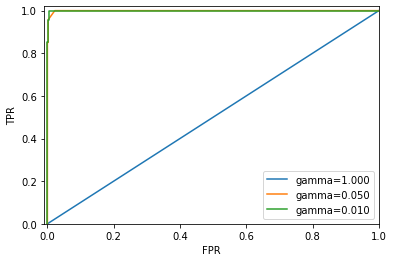

In [84]:
y=digits.target==9

X_train,X_test,y_train,y_test=train_test_split(digits.data,y,random_state=0)

plt.figure()

for gamma in [1,0.05,0.01]:
    svc=SVC(gamma=gamma).fit(X_train,y_train)
    accuracy=svc.score(X_test,y_test)
    auc=roc_auc_score(y_test,svc._decision_function(X_test))
    fpr,tpr,_=roc_curve(y_test,svc._decision_function(X_test))
    print('gamma = {:.2f}  accuracy = {:.2f}  AUC = {:.2f}'.format(gamma,accuracy,auc))
    plt.plot(fpr,tpr,label='gamma={:.3f}'.format(gamma))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.xlim(-0.01,1)
plt.ylim(0,1.02)
plt.legend(loc='best')

* どのgammaに対しても精度は90%だが、AUCと対応するカーブを見ると、gammaの値によってAUCが大きく改善していることがわかる
* gamma=0.01とすると、完全なAUC1.0が得られ、これはすべての陽性データポイントがすべての陰性データポイントよりも、決定関数で良いスコアを得ていることを意味する
* つまり、適切にスレッショルドを設定すれば、このモデルはデータを完璧に分類できる、ということになる
* 偏ったデータを評価する際には、AUCを用いるのが推奨
* AUCはデフォルトのスレッショルドを用いないため、AUCが高いモデルを用いて有用なクラス分類を行うには、スレッショルドを調整する必要があることに留意する

### 5.3.3 多クラス分類の基準
* 他クラス分類の基準はすべて2クラス分類の基準から導出されたもので、すべてのクラスに対して平均をとったもの
* 2クラス分類の場合と同様に、多クラス分類の精度は正確にクラス分類されたサンプルの割合のため、クラス分布が偏ったデータセットの場合には、適切な評価基準ではない


In [87]:
from sklearn.metrics import accuracy_score
X_train,X_test,y_train,y_test=train_test_split(digits.data,digits.target,random_state=0)
lr=LogisticRegression(max_iter=10000).fit(X_train,y_train)
pred=lr.predict(X_test)
print("Accuracy score: {:.3f}".format(accuracy_score(y_test,pred)))
print("Confusion matrix:\n{}".format(confusion_matrix(y_test,pred)))

Accuracy score: 0.953
Confusion matrix:
[[37  0  0  0  0  0  0  0  0  0]
 [ 0 40  0  0  0  0  0  0  2  1]
 [ 0  0 41  3  0  0  0  0  0  0]
 [ 0  0  0 44  0  0  0  0  1  0]
 [ 0  0  0  0 37  0  0  1  0  0]
 [ 0  0  0  0  0 46  0  0  0  2]
 [ 0  1  0  0  0  0 51  0  0  0]
 [ 0  0  0  1  1  0  0 46  0  0]
 [ 0  3  1  0  0  0  1  0 43  0]
 [ 0  0  0  0  0  1  0  0  2 44]]


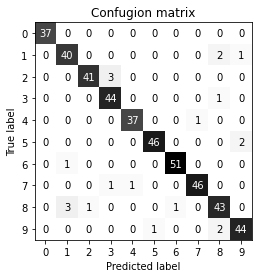

In [88]:
scores_image=mglearn.tools.heatmap(confusion_matrix(y_test,pred),xlabel='Predicted label',ylabel='True label',xticklabels=digits.target_names,yticklabels=digits.target_names,cmap=plt.cm.gray_r,fmt='%d')
plt.title("Confugion matrix")
plt.gca().invert_yaxis()

In [89]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       0.91      0.93      0.92        43
           2       0.98      0.93      0.95        44
           3       0.92      0.98      0.95        45
           4       0.97      0.97      0.97        38
           5       0.98      0.96      0.97        48
           6       0.98      0.98      0.98        52
           7       0.98      0.96      0.97        48
           8       0.90      0.90      0.90        48
           9       0.94      0.94      0.94        47

    accuracy                           0.95       450
   macro avg       0.95      0.95      0.95       450
weighted avg       0.95      0.95      0.95       450



* 偏ったデータセットに対する多クラス分類問題でもっともよく用いられる基準は、多クラス版のf-値
* 多クラス分類のf-値の求め方
* 個々のクラスに対してそのクラスを陽性、他のクラスを陰性として2クラスf-値を計算
* 次に、クラスごとのf-値を次のようにして平均する
* "macro"平均:
    重みを付けずにクラスごとのf-値を平均する.クラスのサイズを考慮せずに、全てのクラスに同じ重みを与える
* "weighted"平均:
    各クラスの支持度に応じて重みを付けて、クラスごとのf-値を平均する.クラス平均レポートで表示されるのはこの値.
* "micro"平均;
    すべてのクラスの偽陽性、偽陰性、真陽性の総数を計算し、その値を用いて、適合率、再現率、f-値を計算する.
* 個々のサンプルを同じように重視するのであれば、"micro"平均のf-値を使う
* 個々のクラスを同じように重視するのであれば、"macro"平均のf-値を使う

In [90]:
print("Micro average f1 score: {:.3f}".format(f1_score(y_test,pred,average="micro")))
print("Macro average f1 score: {:.3f}".format(f1_score(y_test,pred,average="macro")))

Micro average f1 score: 0.953
Macro average f1 score: 0.954


### 5.3.4 回帰の基準
* 平均二乗誤差や平均絶対誤差を使ってビジネス決定を行う場合には、これらの基準でモデルをチューニングする必要があるかもしれないが、回帰モデルを評価する上では、$R^2$が最も直感的な基準

### 5.3.5 評価基準を用いたモデル選定
* GridSearchCVやcross_val_scoreによるモデル選択でAUCのような基準を用いたい場合、scikit-learnではscoringという引数に利用したい評価基準を文字列で与えるだけでよい

In [91]:
# デフォルトのクラス分類スコアは精度
print("Default scoring: {}".format(cross_val_score(SVC(),digits.data,digits.target==9)))
# scoring="accuracy"としても結果は変わらない
explicit_accuracy=cross_val_score(SVC(),digits.data,digits.target==9,scoring="accuracy")
print("Explicit accuracy scoring: {}".format(explicit_accuracy))
roc_auc=cross_val_score(SVC(),digits.data,digits.target==9,scoring="roc_auc")
print("AUC scoring: {}".format(roc_auc))

Default scoring: [0.975      0.99166667 1.         0.99442897 0.98050139]
Explicit accuracy scoring: [0.975      0.99166667 1.         0.99442897 0.98050139]
AUC scoring: [0.99717078 0.99854252 1.         0.999828   0.98400413]


* 同様に、GridSearchCVで最良のパラメータを見つける際の基準も変更することができる

In [93]:
X_train,X_test,y_train,y_test=train_test_split(digits.data,digits.target==9,random_state=0)

# 説明の都合上、あまり良くないグリッドを与える
param_grid={'gamma':[0.001,0.01,0.1,1,10]}
# デフォルトのスコア法である精度で評価
grid=GridSearchCV(SVC(),param_grid=param_grid)
grid.fit(X_train,y_train)
print("Grid-Search with accuracy")
print("Best parmeters: ",grid.best_params_)
print("Best cross-validation score (accuracy): {:.3f}".format(grid.best_score_))
print("Test set AUC: {:.3f}".format(roc_auc_score(y_test,grid.decision_function(X_test))))
print("Test set accuracy: {:.3f}".format(grid.score(X_test,y_test)))

Grid-Search with accuracy
Best parmeters:  {'gamma': 0.001}
Best cross-validation score (accuracy): 0.996
Test set AUC: 1.000
Test set accuracy: 0.991


In [94]:
# AUCをスコアに用いる
grid=GridSearchCV(SVC(),param_grid=param_grid,scoring="roc_auc")
grid.fit(X_train,y_train)
print("Grid-Search with AUC")
print("Best parameters: ",grid.best_params_)
print("Best cross-validation score (AUC): {:.3f}".format(grid.best_score_))
print("Test set AUC: {:.3f}".format(grid.score(X_test,y_test)))

Grid-Search with AUC
Best parameters:  {'gamma': 0.001}
Best cross-validation score (AUC): 0.999
Test set AUC: 1.000


* AUCを用いて見つけたパラメタ-のほうが、AUCだけでなく、精度の面でも良いスコアを示している
* クラス分類におけるscoringパラメータの値として重要なものとしては、accuracy（デフォルト）,roc_auc（ROCカーブのカーブ下領域：AUC）,average_precision（適合率-再現率カーブのカーブ下領域）,f1,f1_macro,f1_micro,f1_weighted（二クラス分類のf1-値と、f1-値のさまざまな重み付け平均）がある
* 回帰でよく用いられるのは、r2（$R^2$スコア）,mean_squared_error（平均二乗誤差）,mean_absolute_error（平均絶対誤差）など
* サポートされている引数の値のリストは、metricsモジュールに定義されているSCORERディクショナリを見るとわかる

In [95]:
from sklearn.metrics import SCORERS
print("Available scorers:\n{}".format(sorted(SCORERS.keys())))

Available scorers:
['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted', 'max_error', 'mutual_info_score', 'neg_brier_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_gamma_deviance', 'neg_mean_poisson_deviance', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'neg_root_mean_squared_error', 'normalized_mutual_info_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'rand_score', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'roc_auc_ovo', 'roc_auc_ovo_weighted', 'roc_auc_ovr', 'roc_auc_ovr_weighted', 'top_k_accuracy', 'v

## 5.4 まとめと展望
* 交差検証もテストセットの利用も機械学習モデルの将来における性能を評価するためのものであるが、テストセットや交差検証をモデルやモデルのパラメータを選択するために用いてしまうと、テストデータを「利用済み」にしてしまう
* このため、同じデータを使って将来におけるモデルの性能を評価すると、過度に楽観的な見積もりが得られてしまう
* モデルを構築するための訓練データとパラメータ選択のための検証データと評価のためのテストデータに分けなければならない
* 最も一般的に用いられるのは、訓練セットとテストセットを評価のために分離し、訓練セットに対して交差検証でパラメータ選択を行う方法
* ビジネス決定においては、高い精度を達成すること自体が機械学習タスクの最終的な目標であることはほとんどない
* モデルの評価や選択に用いる基準が、モデルが実際に利用される際の状況を反映するようにしなければならない
* 現実世界では、クラス分類問題におけるクラスが隔たっていないことはほとんどないし、偽陽性と偽陰性の結果が大きく異る場合が多い